In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, make_scorer
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from pykalman import KalmanFilter
import numpy as np
from tqdm import tqdm
import os
from scipy.signal import find_peaks

# 1) ML-решение

In [17]:
df = pd.read_csv('data/PPG_Dataset.csv')
X = df.drop(columns=['Label'])
y = df['Label']
y = y.apply(lambda label: 1 if label == 'MI' else 0)
df


,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Label
0,-0.015552,0.016963,0.013575,0.027204,0.068154,0.129259,0.127915,0.345174,0.197811,0.167651,...,-0.426464,-0.346976,-0.132168,-0.252098,-0.241969,-0.134235,-0.091327,-0.081713,-0.057693,MI
1,0.002323,0.002754,0.022539,0.228807,0.107751,0.034439,0.086007,0.155667,0.163327,0.223759,...,-0.169345,-0.356808,-0.338996,-0.292489,-0.152872,-0.156076,-0.103265,-0.041579,-0.044272,MI
2,0.050481,-0.339781,0.265111,0.045092,0.040086,0.087173,0.092814,0.099586,-0.143305,0.164186,...,-0.401426,-0.402333,-0.373426,-0.303710,0.008599,-0.180633,-0.143135,-0.084758,0.060668,MI
3,0.023882,0.016561,0.248547,0.054567,0.128032,0.085954,0.107359,0.207137,0.174547,-0.100118,...,-0.390700,-0.353882,-0.294014,-0.267005,-0.242258,-0.186946,-0.173718,0.101331,0.063555,MI
4,-0.058591,0.171551,0.057262,0.270869,0.138357,0.078509,0.062504,0.104447,0.134795,0.194248,...,-0.391598,-0.334490,-0.326873,-0.249881,-0.210052,-0.194763,-0.415365,0.015432,0.010321,MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,-0.324640,-0.002758,0.032419,0.064355,0.058884,0.084295,0.113157,0.099573,0.161287,0.182989,...,-0.457989,-0.355685,-0.107379,-0.229693,-0.177197,-0.203492,-0.128723,-0.024295,-0.045567,MI
2572,0.237585,0.061030,0.072820,0.031893,0.114808,0.062936,0.307315,0.126924,0.392320,0.195136,...,-0.437642,-0.321945,-0.303451,-0.197557,-0.229486,-0.134217,-0.119387,-0.000022,-0.027357,MI
2573,0.016238,0.042248,0.042416,0.056881,0.058588,0.108145,0.095167,0.126091,0.163083,0.153061,...,-0.250780,-0.158280,-0.141116,-0.155825,-0.117786,-0.063283,-0.056181,-0.053293,0.007894,Normal
2574,0.002446,0.052906,0.050302,0.066125,0.052302,0.058444,0.048659,0.131709,0.129861,0.172007,...,-0.437347,-0.297214,-0.312739,-0.241026,-0.204217,-0.147206,-0.052625,-0.054537,0.006880,MI


In [3]:
y.value_counts()

MI        1294
Normal    1282
Name: Label, dtype: int64

### Построим графики нескольких сэмплов

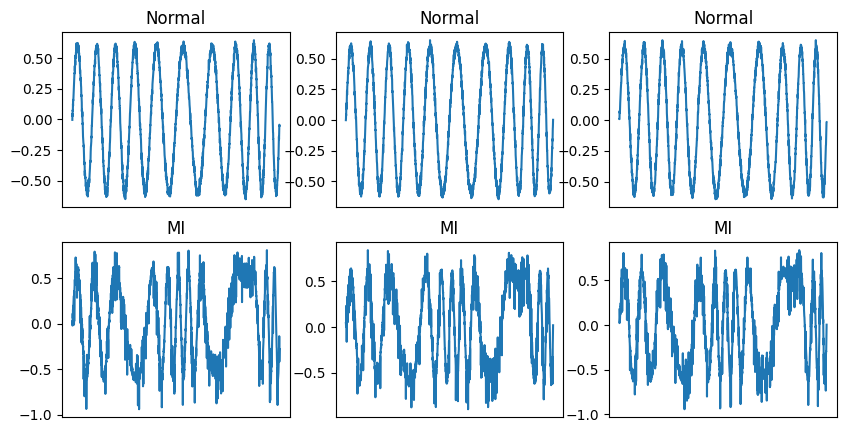

In [75]:
normal_indices = random.sample(set(df[df['Label'] == 'Normal'].index), 3)
mi_indices = random.sample(set(df[df['Label'] == 'MI'].index), 3)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i in range(3):
    axes[0, i].plot(X.loc[normal_indices[i]])
    axes[0, i].set_title('Normal')
    axes[0, i].set_xticks([])

for i in range(3):
    axes[1, i].plot(X.loc[mi_indices[i]])
    axes[1, i].set_title('MI')
    axes[1, i].set_xticks([])
# axes[1].plot(X.loc[2574])
# axes[1].set_title('MI')
plt.show()

### Выделим некоторые признаки из рядов показаний с помощью TSfresh

Преобразуем данные в long формат, которого требует tsfresh

In [11]:
def reshape_to_long_format(data):
    long_data = []
    for i, row in data.iterrows():
        for t, value in enumerate(row):
            long_data.append([i, t, value])
    return pd.DataFrame(long_data, columns=['id', 'time', 'value'])

long_data = reshape_to_long_format(X)

In [12]:
long_data.shape

(5152000, 3)

In [13]:
long_data

,id,time,value
0,0,0,-0.015552
1,0,1,0.016963
2,0,2,0.013575
3,0,3,0.027204
4,0,4,0.068154
...,...,...,...
5151995,2575,1995,-0.121540
5151996,2575,1996,-0.106121
5151997,2575,1997,-0.098251
5151998,2575,1998,-0.027523


In [14]:
if os.path.exists('data/extracted_features.csv'):
    extracted_features = pd.read_csv('data/extracted_features.csv')
else:
    extracted_features = extract_features(long_data, column_id='id', column_sort='time')
    impute(extracted_features)
    extracted_features.to_csv('data/extracted_features.csv')

Feature Extraction: 100%|██████████| 30/30 [32:41<00:00, 65.37s/it]  
/home/alex/.local/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       0.0                   0.0          31.157460   
1                       0.0                   0.0          35.008497   
2                       0.0                   0.0          29.853268   
3                       0.0                   0.0          37.000555   
4                       0.0                   0.0          29.006665   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
0         385.945107    

In [15]:
extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,31.157460,385.945107,0.076815,-0.000021,-2.126089e-06,0.033323,...,0.170467,0.170467,0.226363,1.783547,3.131116,4.628247,6.104146,7.001843,0.0,0.891275
1,0.0,0.0,0.0,0.0,35.008497,383.544686,0.077898,-0.000023,-7.819507e-07,0.040070,...,0.170467,0.170467,0.226363,1.783283,3.131496,4.639577,6.123029,7.020989,0.0,0.909372
2,0.0,0.0,0.0,0.0,29.853268,390.247977,0.078017,0.000005,1.340559e-04,0.038146,...,0.170467,0.170467,0.226363,1.784719,3.122319,4.604906,6.061805,6.984226,0.0,0.908856
3,0.0,0.0,0.0,0.0,37.000555,389.517027,0.075757,0.000020,-7.621493e-06,0.038695,...,0.136002,0.181214,0.226363,1.782757,3.130776,4.633616,6.100513,7.031413,0.0,0.903145
4,0.0,0.0,0.0,0.0,29.006665,387.874149,0.085458,0.000034,-5.887202e-05,0.021362,...,0.170467,0.170467,0.226363,1.786521,3.148947,4.677288,6.209533,7.121694,0.0,0.914211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,0.0,0.0,0.0,0.0,36.931273,385.777835,0.072992,0.000140,-8.587428e-05,0.038798,...,0.170467,0.170467,0.226363,1.782007,3.119638,4.611725,6.075621,6.965655,0.0,0.901361
2572,0.0,0.0,0.0,0.0,42.933851,390.687883,0.072834,-0.000133,3.734259e-05,0.024034,...,0.170467,0.170467,0.226363,1.783729,3.129227,4.623480,6.098806,6.995068,0.0,0.910804
2573,0.0,0.0,0.0,0.0,7.382986,360.821740,0.025227,-0.000004,8.803149e-06,0.011706,...,0.090729,0.136002,0.181214,1.770969,3.010773,4.286397,5.440401,6.222825,0.0,0.640998
2574,0.0,0.0,0.0,0.0,35.077470,393.101834,0.069541,0.000002,2.741952e-06,0.033762,...,0.170467,0.170467,0.226363,1.785916,3.140878,4.649605,6.108666,7.019329,0.0,0.895698


Удалим колонки, полностью заполненные нулями

In [ ]:
cols_to_drop = list(extracted_features.columns[(extracted_features==0).all()])
extracted_features = extracted_features.drop(columns=cols_to_drop)

In [27]:
extracted_features

,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,31.157460,385.945107,0.076815,-0.000021,-2.126089e-06,0.033323,0.015579,2000.0,0.439010,...,0.079983,0.170467,0.170467,0.226363,1.783547,3.131116,4.628247,6.104146,7.001843,0.891275
1,0.0,35.008497,383.544686,0.077898,-0.000023,-7.819507e-07,0.040070,0.017504,2000.0,0.437568,...,0.079983,0.170467,0.170467,0.226363,1.783283,3.131496,4.639577,6.123029,7.020989,0.909372
2,0.0,29.853268,390.247977,0.078017,0.000005,1.340559e-04,0.038146,0.014927,2000.0,0.441476,...,0.079983,0.170467,0.170467,0.226363,1.784719,3.122319,4.604906,6.061805,6.984226,0.908856
3,0.0,37.000555,389.517027,0.075757,0.000020,-7.621493e-06,0.038695,0.018500,2000.0,0.440927,...,0.079983,0.136002,0.181214,0.226363,1.782757,3.130776,4.633616,6.100513,7.031413,0.903145
4,0.0,29.006665,387.874149,0.085458,0.000034,-5.887202e-05,0.021362,0.014503,2000.0,0.440144,...,0.079983,0.170467,0.170467,0.226363,1.786521,3.148947,4.677288,6.209533,7.121694,0.914211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,0.0,36.931273,385.777835,0.072992,0.000140,-8.587428e-05,0.038798,0.018466,2000.0,0.438803,...,0.079983,0.170467,0.170467,0.226363,1.782007,3.119638,4.611725,6.075621,6.965655,0.901361
2572,0.0,42.933851,390.687883,0.072834,-0.000133,3.734259e-05,0.024034,0.021467,2000.0,0.441456,...,0.079983,0.170467,0.170467,0.226363,1.783729,3.129227,4.623480,6.098806,6.995068,0.910804
2573,0.0,7.382986,360.821740,0.025227,-0.000004,8.803149e-06,0.011706,0.003691,2000.0,0.424732,...,0.090729,0.090729,0.136002,0.181214,1.770969,3.010773,4.286397,5.440401,6.222825,0.640998
2574,0.0,35.077470,393.101834,0.069541,0.000002,2.741952e-06,0.033762,0.017539,2000.0,0.442994,...,0.079983,0.170467,0.170467,0.226363,1.785916,3.140878,4.649605,6.108666,7.019329,0.895698


### Обучим Random Forest на извлеченных признаках и посмотрим на результаты

Разбиение и на трейн и тест и обучение модели

In [38]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

In [39]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для ROC-AUC

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9632
F1-Score: 0.9627
ROC-AUC: 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       260
           1       0.97      0.96      0.96       256

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516



Кросс-валидация на 5 фолдах

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

cv_results = cross_validate(
    model,
    extracted_features,   
    y,  
    cv=5,  
    scoring=scoring,
    return_train_score=False 
)

print(f"Средняя Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Средний F1-Score: {cv_results['test_f1'].mean():.4f}")
print(f"Средний ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")

Средняя Accuracy: 0.9643
Средний F1-Score: 0.9636
Средний ROC-AUC: 0.9634


# 2) Пороговый классификатор

## Фильтр Калмана

In [18]:
if os.path.exists('data/kalman_ppg.npy'):
    kalman_data = np.load('data/kalman_ppg.npy')
    
else:
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=0.1,
        transition_covariance=0.01 
    )

    kalman_data = np.zeros_like(X)

    for i, row in tqdm(X.iterrows()):
        filtered_state_means, _ = kf.filter(row)
        kalman_data[i, :] = filtered_state_means.flatten()
        
    np.save('data/kalman_ppg.npy', kalman_data)

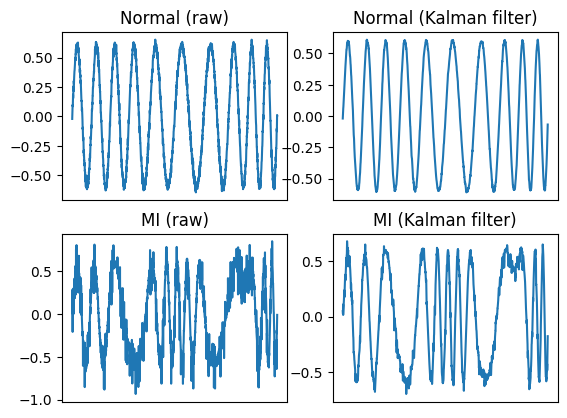

In [19]:
normal_indices = random.sample(set(df[df['Label'] == 'Normal'].index), 1)
mi_indices = random.sample(set(df[df['Label'] == 'MI'].index), 1)

fig, axes = plt.subplots(2, 2)
axes[0][0].plot(X.loc[normal_indices[0]])
axes[0][0].set_title('Normal (raw)')
axes[0][1].plot(kalman_data[normal_indices[0]])
axes[0][1].set_title('Normal (Kalman filter)')

axes[1][0].plot(X.loc[mi_indices[0]])
axes[1][0].set_title('MI (raw)')
axes[1][1].plot(kalman_data[mi_indices[0]])
axes[1][1].set_title('MI (Kalman filter)')

for i in range(2):
    for j in range(2):
        axes[i, j].set_xticks([])


plt.show()

Из графиков видно, что сигнал при инфаркте в основном отличается частотой пульса, визуально можно разбить график на 3 равные по времени части.

In [20]:
def count_peaks(signal):
    peaks, _ = find_peaks(signal)
    return len(peaks)

sampling_rate = 100

pulse_frequencies = []
p1 = int(kalman_data.shape[1] / 3)
p2 = int(2 * kalman_data.shape[1] / 3)
for signal in tqdm(kalman_data):
    cur_signal_freq = []
    for sig_part in [signal[:p1], signal[p1:p2], signal[p2:]]:
        num_peaks = count_peaks(sig_part)  # Количество пиков
        duration = len(sig_part) / sampling_rate  # Длительность сигнала в секундах
        pulse_frequency = num_peaks / duration  # Частота пульса (пиков в секунду)
        cur_signal_freq.append(pulse_frequency)
    pulse_frequencies.append(cur_signal_freq)

100%|██████████| 2576/2576 [00:00<00:00, 34547.84it/s]


In [21]:
features_df = pd.DataFrame(pulse_frequencies, columns=['part1_freq', 'part2_freq', 'part3_freq'])
features_df['amplitude'] = np.max(kalman_data, axis=1)
features_df['mean_ppg_value'] = np.mean(kalman_data, axis=1)
features_df['freq_rel'] = features_df['part2_freq'] / np.mean(np.array([list(features_df['part1_freq']), list(features_df['part3_freq'])]), axis=0)
features_df['sum_freqs'] = features_df['part1_freq'] + features_df['part2_freq'] + features_df['part3_freq']

Сгладив сигналы фильтром Калмана, я посчитал частоту пульса на каждом из 3 промежутков, суммарную частоту пульса на этих 3 промежутках, среднее значение PPG на всем промежутке, амплитуду и отношение частоты пульса на среднем промежутке к средней частоте пульса на крайних промежутках.

In [26]:
features_df_normal = features_df[y == 0]
features_df_mi = features_df[y == 1]

Теперь проанализируем эти признаки у PPG с инфарктом и у нормальных PPG по отдельности

In [27]:
features_df_normal.describe()

,part1_freq,part2_freq,part3_freq,amplitude,mean_ppg_value,freq_rel,sum_freqs
count,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000
mean,6.045242,8.147525,6.426896,0.615387,0.003731,1.341818,20.619663
std,1.794272,0.963604,1.900760,0.010959,0.002144,0.186221,4.296989
min,3.903904,5.547226,4.047976,0.602292,0.001979,0.642696,17.098208
25%,5.405405,7.496252,5.697151,0.611037,0.003095,1.235945,19.198734
50%,5.855856,8.095952,6.146927,0.613724,0.003392,1.341151,19.948584
75%,6.156156,8.545727,6.596702,0.616307,0.003710,1.448967,20.698885
max,18.168168,13.943028,19.790105,0.722531,0.019904,1.998500,49.502501


In [28]:
features_df_mi.describe()

,part1_freq,part2_freq,part3_freq,amplitude,mean_ppg_value,freq_rel,sum_freqs
count,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000
mean,16.100993,11.946152,16.664040,0.672590,0.015847,0.747563,44.711185
std,2.431350,1.268716,2.452757,0.021010,0.003266,0.143078,5.629966
min,4.654655,6.446777,5.397301,0.607071,0.002329,0.514390,18.149259
25%,15.765766,11.394303,16.341829,0.661738,0.014987,0.680711,44.548672
50%,16.516517,11.994003,17.091454,0.672090,0.016232,0.722655,45.750773
75%,17.267267,12.743628,17.841079,0.685430,0.017593,0.765981,46.953044
max,19.969970,15.742129,21.139430,0.747895,0.022262,1.694978,51.750026


Из табличек describe видно, что наиболее отличается сумма частот пульс, при инфаркте она сильно выше, а также среднее значение PPG, которое также выше при инфаркте. Переберем набор значений каждого из этих признаков и выявим лучшие пороговые значения основываясь на метрике F1-score.
Если у сигнала значение одного из вышеописанных признаков (логическое или) больше его порогового значения, то мы говорим, что сигнал соответстует инфаркту, иначе - норме.

In [35]:
class KalmanThresholdClassifier:
    def __init__(self):
        self.best_ppg_th = None
        self.best_sum_freqs_th = None
    
    def fit(self, features_df, y):
        best_f1_kalman = 0
        accuracy_kalman = 0
        for sum_freqs_th in tqdm(np.arange(18, 40.1, 0.05)):
            for mean_ppg_th in np.arange(0.002, 0.025, 0.001):
                y_pred = np.array(np.logical_or(features_df['sum_freqs']>sum_freqs_th, features_df['mean_ppg_value']>mean_ppg_th), dtype=int)
                f1_cur = f1_score(y, y_pred)
                if f1_cur > best_f1_kalman:
                    best_f1_kalman = f1_cur
                    accuracy_kalman = accuracy_score(y, y_pred)
                    self.best_ppg_th = mean_ppg_th
                    self.best_sum_freqs_th = sum_freqs_th
        
        return self
    
    def predict(self, X):
        y_pred = np.array(np.logical_or(X['sum_freqs']> self.best_sum_freqs_th, X['mean_ppg_value']>self.best_ppg_th), dtype=int)
        return y_pred
    
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

Сделаем кросс-валидацию нашего порогового классификатора на 5 фолдах

In [36]:
kalman_clf = KalmanThresholdClassifier()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    kalman_clf,
    features_df,   
    y,  
    cv=5,  
    scoring=scoring,
    return_train_score=False 
)

print(f"Средняя Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Средний F1-Score: {cv_results['test_f1'].mean():.4f}")

100%|██████████| 442/442 [00:16<00:00, 27.25it/s]

Средняя Accuracy: 0.9635
Средний F1-Score: 0.9631


Полученные метрики почти полностью совпадают с метриками, полученными ML решением.

## Сверточные оконные фильтры

Для начала используем фильтр скользящего среднего

In [37]:
kernel = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [38]:
#применяю фильтр 40 раз, чтобы полностью избавиться от шума
conv_X = X.copy()
for i in range(40):
    conv_X = conv_X.apply(lambda row: np.convolve(row, kernel, mode='same'), axis=1)
    conv_X = pd.DataFrame(conv_X.tolist(), columns=X.columns)

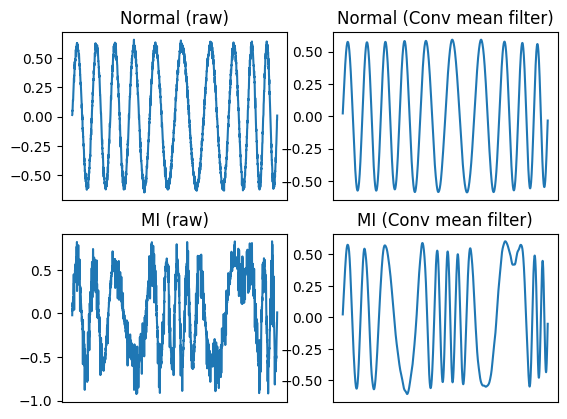

In [39]:
normal_indices = random.sample(set(df[df['Label'] == 'Normal'].index), 1)
mi_indices = random.sample(set(df[df['Label'] == 'MI'].index), 1)

fig, axes = plt.subplots(2, 2)
axes[0][0].plot(X.loc[normal_indices[0]])
axes[0][0].set_title('Normal (raw)')
axes[0][1].plot(conv_X.loc[normal_indices[0]])
axes[0][1].set_title('Normal (Conv mean filter)')

axes[1][0].plot(X.loc[mi_indices[0]])
axes[1][0].set_title('MI (raw)')
axes[1][1].plot(conv_X.loc[mi_indices[0]])
axes[1][1].set_title('MI (Conv mean filter)')

for i in range(2):
    for j in range(2):
        axes[i, j].set_xticks([])


plt.show()

Как мы видим, сигнал довольно сильно сгладился, шумы полностью удалены

Теперь к сигналу, очищенному от шумов, применим фильтр для выделения пиков

In [51]:
peaks_kernel = [-1, 0, 1]

In [52]:
peaks_conv_X = conv_X.apply(lambda row: np.convolve(row, peaks_kernel, mode='same'), axis=1)

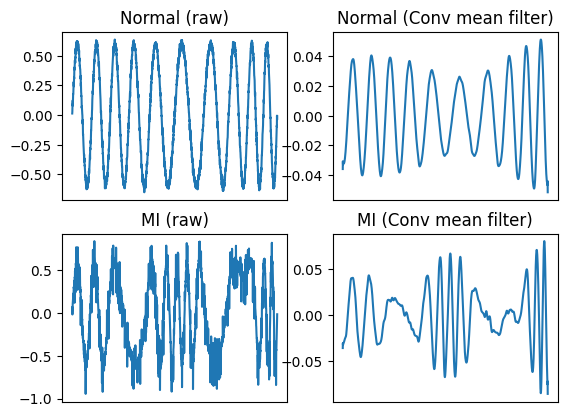

In [53]:
normal_indices = random.sample(set(df[df['Label'] == 'Normal'].index), 1)
mi_indices = random.sample(set(df[df['Label'] == 'MI'].index), 1)

fig, axes = plt.subplots(2, 2)
axes[0][0].plot(X.loc[normal_indices[0]])
axes[0][0].set_title('Normal (raw)')
axes[0][1].plot(peaks_conv_X[normal_indices[0]])
axes[0][1].set_title('Normal (Conv mean filter)')

axes[1][0].plot(X.loc[mi_indices[0]])
axes[1][0].set_title('MI (raw)')
axes[1][1].plot(peaks_conv_X[mi_indices[0]])
axes[1][1].set_title('MI (Conv mean filter)')

for i in range(2):
    for j in range(2):
        axes[i, j].set_xticks([])


plt.show()

Несложно заметить, что после применения фильтра в центральной части сигнала максимальное значение PPG (амплитуда) в случаях с инфарктом сильно выше, чем в нормальных случаях. Найдем лучший порог амплитуды и классифицируем сигналы по этому порогу.

In [ ]:
#заполняю массив амплитуд средней трети графика
peaks_conv_X = np.array(peaks_conv_X.tolist())

def count_peaks(signal):
    peaks, _ = find_peaks(signal)
    return len(peaks)

max_vals = []
p1 = int(peaks_conv_X.shape[1] / 3)
p2 = int(2 * peaks_conv_X.shape[1] / 3)
for signal in tqdm(peaks_conv_X):
    middle_part = signal[p1:p2]
    max_val = max(abs(np.max(middle_part)), abs(np.min(middle_part)))
    max_vals.append(max_val)

max_vals = np.array(max_vals)

100%|██████████| 2576/2576 [00:00<00:00, 122328.33it/s]


In [58]:
class AmplitudeThresholdClassifier:
    def __init__(self):
        self.best_max_val_th = None
    
    def fit(self, max_vals, y):
        best_f1_conv = 0
        accuracy_conv = 0
        for max_val_th in tqdm(np.arange(0.03, 0.075, 0.0005)):
            y_pred = (max_vals > max_val_th).astype(int)
            f1_cur = f1_score(y, y_pred)
            if f1_cur > best_f1_conv:
                best_f1_conv = f1_cur
                accuracy_conv = accuracy_score(y, y_pred)
                self.best_max_val_th = max_val_th
        
        return self
    
    def predict(self, max_vals):
        y_pred = (max_vals > self.best_max_val_th).astype(int)
        return y_pred
    
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

Сделаем кросс-валидацию нашего порогового классификатора на 5 фолдах

In [62]:
amplitude_clf = AmplitudeThresholdClassifier()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(
    amplitude_clf,
    max_vals,   
    y,  
    cv=5,  
    scoring=scoring,
    return_train_score=False 
)

print(f"Средняя Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Средний F1-Score: {cv_results['test_f1'].mean():.4f}")

100%|██████████| 90/90 [00:00<00:00, 763.27it/s]

Средняя Accuracy: 0.9639
Средний F1-Score: 0.9636


Метрики получились почти такими же, как и у порогового классификатора в пункте про фильтр Калмана и у Random Forest.

# Преобразование Фурье